In [1]:
from utt_encoding import UtteranceEncoding
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
import pandas as pd
import re
import os
import io
from contextlib import redirect_stdout
from helper import f1_score, accuracy, precision, recall

In [2]:
def string_prop(dp_content):
    dp_content = dp_content.replace("!=", "does not equal").replace("=", "equals").\
    replace("<", "is less than").replace(">", "is more than").\
    replace("+", "plus").replace("10", "ten").replace("20", "twenty").replace("30", "thirty").\
    replace("40", "forty").replace("50","fifty").replace("red", "red block").replace("blue", "blue block").\
    replace("yellow", "yellow block").replace("purple", "purple block").replace("green", "green block")
    return dp_content

In [3]:
def unstring_prop(dp_content):
    dp_content = dp_content.replace("equals","=").replace("does not equal","!=").\
    replace("is less than","<").replace("is more than",">").\
    replace("plus","+").replace("ten","10").replace("twenty","20").replace("thirty","30").\
    replace("forty","40").replace("fifty","50").replace(" block","")
    return dp_content

In [4]:
def calculate_iou(common_ground, actual_common_ground):
    # Split by ',' and strip whitespace from each element
    common_ground_elements = set([element.strip() for element in common_ground.split(',')])
    actual_common_ground_elements = set([element.strip() for element in actual_common_ground.split(',')])
    # Calculate intersection and union
    intersection = common_ground_elements & actual_common_ground_elements
    union = common_ground_elements | actual_common_ground_elements
    # Calculate IoU
    iou = len(intersection) / len(union) if union else 0
    return iou

In [5]:
number_mapping = {
    "ten": 10, "twenty": 20, "thirty": 30, 
    "forty": 40, "fifty": 50
}

In [6]:
def extract_colors_and_numbers(text):
    colors = ["red", "blue", "green", "yellow", "purple"]
    numbers = list(number_mapping.keys())
    found_elements = {"colors": [], "numbers": []}
    for color in colors:
        if color in text:
            found_elements["colors"].append(color)
    for number in numbers:
        if number in text:
            found_elements["numbers"].append(number_mapping[number])
    return found_elements

In [7]:
def is_valid_common_ground(cg, elements):
    cg_colors = re.findall(r'\b(?:red|blue|green|yellow|purple)\b', cg)
    cg_numbers = [int(num) for num in re.findall(r'\b(?:10|20|30|40|50)\b', cg)]
    #print(cg_colors, cg_numbers)
    color_match = not elements["colors"] or set(cg_colors) == set(elements["colors"])
    number_match = not elements["numbers"] or set(cg_numbers) == set(elements["numbers"])
    return color_match and number_match

In [8]:
def normalize_sub_expression(sub_expr):
    # Identify the first operator and split the expression around it
    match = re.search(r'([=!<>]+)', sub_expr)
    if match:
        operator = match.group(1)
        parts = re.split(r'([=!<>]+)', sub_expr, 1)
        left_side = parts[0].strip()
        right_side = parts[2].strip()

        # Normalize right side if there is a '+' or for '=', '!=' without '+'
        if '+' in right_side:
            right_side_components = re.findall(r'\w+', right_side)
            right_side_sorted = ' + '.join(sorted(right_side_components))
            return f"{left_side} {operator} {right_side_sorted}"
        elif operator in ['=', '!=']:
            # For '=' and '!=', sort operands alphabetically if no '+' on the right side
            if not right_side.isdigit() and left_side > right_side:  # Avoid sorting number assignments
                return f"{right_side} {operator} {left_side}"
            else:
                return sub_expr
        else:
            # For '<' and '>', return as is when no '+' on the right side
            return sub_expr
    else:
        # Return the expression as is if it doesn't match the above conditions
        return sub_expr

In [9]:
def normalize_expression(expr):
    # Split the expression into sub-expressions by commas for separate processing
    sub_expressions = expr.split(',')
    normalized_sub_expressions = [normalize_sub_expression(sub.strip()) for sub in sub_expressions]
    # Sort the equalities if they involve simple color and number assignments
    if all('=' in sub and (sub.strip().split('=')[0].strip().isalpha() and sub.strip().split('=')[1].strip().isdigit()) for sub in normalized_sub_expressions):
        normalized_sub_expressions.sort()
    return ', '.join(normalized_sub_expressions)

In [10]:
def is_valid_individual_match(cg, elements):
    cg_colors = re.findall(r'\b(?:red|blue|green|yellow|purple)\b', cg)
    cg_numbers = [int(num) for num in re.findall(r'\b(?:10|20|30|40|50)\b', cg)]

    for color in elements["colors"]:
        for number in elements["numbers"]:
            if color in cg_colors and number in cg_numbers:
                return True
    return False

In [11]:
def is_proposition_present(correct_proposition, filtered_common_grounds):
    # Normalize the correct proposition to match the format of filtered common grounds
    normalized_correct_proposition = normalize_expression(correct_proposition)
    return normalized_correct_proposition in filtered_common_grounds

In [12]:
def broaden_search_with_colors(common_grounds, mentioned_colors):
    # Filter common grounds to include those mentioning any of the mentioned colors
    broadened_common_grounds = [cg for cg in common_grounds if any(color in cg for color in mentioned_colors)]
    return broadened_common_grounds

In [13]:
def broaden_search_with_numbers(common_grounds, mentioned_numbers):
    # Filter common grounds to include those mentioning any of the mentioned numbers
    
    broadened_common_grounds = [cg for cg in common_grounds if any(str(number) in cg for number in mentioned_numbers)]
    return broadened_common_grounds

In [14]:
llm = "bert"
llm = "LF"
llm = "roberta"
def get_props(llm):
    props = list(pd.read_csv("NormalizedList.csv")["Propositions"])
    for id, prop in enumerate(props):
        props[id] = string_prop(prop)
    f = io.StringIO()
    with redirect_stdout(f):
        utterance_encoder = UtteranceEncoding(props, llm)
    return llm, props, utterance_encoder

In [15]:
data_paths = [file for file in os.listdir() if 'preprocessed' in file.lower()]
llms = ["bert-base-uncased", "roberta-base", "allenai/longformer-base-4096"]

In [16]:
def get_results(llm, data_path, pruning, props, utterance_encoder):
    
    top_max = 5
    iou = []
    y_true = []
    y_pred = []
    acc_1, acc_3, acc_top_max = 0, 0, 0
    data_file = pd.read_csv(data_path)
    data_file = data_file[data_file["Label"]==1]
    spreadsheet = pd.DataFrame()
    for row_id, utterance in enumerate(data_file["Transcript"]):
        
        filtered_common_grounds = props
        if pruning:
            elements = extract_colors_and_numbers(utterance.lower())
            filtered_common_grounds = [cg for cg in props if is_valid_common_ground(unstring_prop(cg), elements)]
            filtered_common_grounds = [normalize_expression(unstring_prop(expr)) for expr in filtered_common_grounds]
            if not filtered_common_grounds:  # If no match found, try individual color-number pairs
                filtered_common_grounds = [cg for cg in props if is_valid_individual_match(unstring_prop(cg), elements)]
            filtered_common_grounds = [expr.replace(' block', '') for expr in filtered_common_grounds]
            filtered_common_grounds = [string_prop(expr) for expr in filtered_common_grounds]
        
        tokenized_text, seq_embedding, pooled_embedding, hidden_states = \
                            utterance_encoder.get_sentence_embedding(utterance,
                            utterance_encoder.llm_tokenizer,
                            utterance_encoder.llm_model)
        token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0), dim=1).permute(1,0,2)
        sum_embeddings = utterance_encoder.get_token_embeddings(token_embeddings, 4)
        utterance_embedding = torch.mean(torch.stack(sum_embeddings[:-1]),axis=0)
        similarities = []
        
        for prop in filtered_common_grounds:        
            utterance_encoder.prop_embs[prop]
            similarities.append(cos_sim(utterance_embedding.reshape(1,-1),\
                utterance_encoder.prop_embs[prop].reshape(1,-1))[0][0])
        true_prop = data_file.iloc[row_id]["Common Ground"]
        try:
            y_true.append(props.index(string_prop(true_prop)))
        except:
            y_true.append(props.index(props[0]))

        dp_content = unstring_prop(filtered_common_grounds[np.argmax(np.array(similarities))])
        y_pred.append(props.index(string_prop(dp_content)))
        iou.append(calculate_iou(dp_content, true_prop))
        
        if dp_content == true_prop:
            acc_1 += 1
        
        for prop_3 in np.array(similarities).argsort()[::-1][:3]:
            dp_content = unstring_prop(filtered_common_grounds[prop_3])
            if dp_content == true_prop:
                acc_3 += 1

        tmp = {}
        tmp["Utt_id"] = row_id
        tmp["Transcript"] = utterance
        tmp["Ground truth"] = true_prop
        tmp["Correct"] = 0
        for i, prop_top_max in enumerate(np.array(similarities).argsort()[::-1][:top_max]):
            dp_content = unstring_prop(filtered_common_grounds[prop_top_max])
            if dp_content == true_prop:
                acc_top_max += 1
                tmp["Correct"] = i+1
            tmp["Top "+ str(i+1)+ " prop"] = dp_content
            tmp["Top "+ str(i+1)+ " cosim"] = np.sort(np.array(similarities))[::-1][:top_max][i]
            tmp["Top "+ str(i+1)+ " IOU"] = calculate_iou(dp_content, true_prop)
        df_dictionary = pd.DataFrame([tmp])
        spreadsheet = pd.concat([spreadsheet, df_dictionary], ignore_index=True)

    spreadsheet.to_csv("DP_"+'bert_'*('bert-base' in llm)+'roberta_'*('roberta' in llm)+'LF_'*('longformer' in llm)+str(data_path[:6])+'_'+str(data_path[-10:-4])+'_pruned'*pruning+".csv", index=False)
    print('bert_'*('bert-base' in llm)+'roberta_'*('roberta' in llm)+'LF_'*('longformer' in llm)+str(data_path[:6])+'_'+str(data_path[-10:-4])+'_pruned'*pruning)
    print(f'IOU = {sum(iou)/len(iou)}')
    print(f"accuracy {accuracy(torch.Tensor(y_pred), torch.Tensor(y_true))}")
    print(f"TOP-1 accuracy {acc_1/len(iou)}")
    print(f"TOP-3 accuracy {acc_3/len(iou)}")
    print(f"TOP-5 accuracy {acc_top_max/len(iou)}")
    print(f"precision {precision(torch.Tensor(y_pred), torch.Tensor(y_true))}")
    print(f"recall {recall(torch.Tensor(y_pred), torch.Tensor(y_true))}")
    print(f"F1 {f1_score(torch.Tensor(y_pred), torch.Tensor(y_true))}")
    print()


In [49]:
for llm in llms:
    llm, props, utterance_encoder = get_props(llm)
    for data_path in data_paths:
        for pruning in [True, False]:
            get_results(llm, data_path, pruning, props, utterance_encoder)


bert_oracle_level1_pruned
IOU = 0.4092132505175983
accuracy 0.373913049697876
TOP-1 accuracy 0.3739130434782609
TOP-3 accuracy 0.5130434782608696
TOP-5 accuracy 0.6260869565217392
precision 0.0013798101572319865
recall 0.001985440030694008
F1 0.0016281286953017116

bert_oracle_level1
IOU = 0.1372463768115942
accuracy 0.11304347962141037
TOP-1 accuracy 0.11304347826086956
TOP-3 accuracy 0.19130434782608696
TOP-5 accuracy 0.21739130434782608
precision 0.0021957270801067352
recall 0.0020054951310157776
F1 0.002096304204314947

bert_google_level1_pruned
IOU = 0.16366366366366364
accuracy 0.14414414763450623
TOP-1 accuracy 0.14414414414414414
TOP-3 accuracy 0.1981981981981982
TOP-5 accuracy 0.26126126126126126
precision 0.003553128568455577
recall 0.002070032525807619
F1 0.002615999197587371

bert_google_level1
IOU = 0.04279279279279279
accuracy 0.036036036908626556
TOP-1 accuracy 0.036036036036036036
TOP-3 accuracy 0.07207207207207207
TOP-5 accuracy 0.11711711711711711
precision 0.00445298

In [1]:
import pandas as pd

Comparing Cosine (w pruning) vs XE on oracle level 1

In [2]:
xe = pd.read_csv("BERTLevel1Transformed.csv")
cos = pd.read_csv("DP_bert_oracle_level1_pruned.csv")
df = pd.merge(xe, cos, on="Transcript", how="inner", suffixes=("xe", 'cos'))
df.to_csv("comparing lv1 oracle.csv")

In [36]:
df[(df["Correctxe"]  > df["Correctcos"]) & (df["Correctcos"] != 0)] # 11 times cos was better 

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
2,'s 's almost settled yellow block 's less fifty,yellow < 50,3,yellow = 50,0.933118,yellow > 50,0.275606,yellow < 50,0.126521,yellow != 50,...,0.0,yellow = 50,0.727650,0.0,yellow != 50,0.638545,0.0,NaN,NaN,NaN
4,"'s stuff written bottom 's red block , green b...","green = 20, red = 10",2,"green = 10, red = 20",0.149531,"green = 20, red = 10",0.104145,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Look thirty gram block,purple = 30,5,green = 30,0.622453,"green = 30, purple = 30",0.588718,yellow = 30,0.579882,red = 30,...,1.0,green = 30,0.819266,0.0,red = 30,0.812679,0.0,yellow = 30,0.805968,0.0
22,Ooh looking thirty,purple = 30,2,yellow = 30,0.514853,purple = 30,0.508945,green = 30,0.508737,red = 30,...,0.0,red = 30,0.705130,0.0,green = 30,0.703837,0.0,yellow = 30,0.682496,0.0
46,"green block , red block , purple block equal g...",purple = green + red,3,red = green + purple,0.720312,green = purple + red,0.682300,purple = green + red,0.677702,green < purple + red,...,0.0,green = purple + red,0.848967,0.0,"green = 10, purple = 10, red = 10",0.845086,0.0,"green = 40, purple = 40, red = 40",0.842452,0.0
64,oh yellow block 's forty,yellow > 40,4,yellow = 40,0.756440,yellow != 40,0.005680,yellow < 40,0.005295,yellow > 40,...,0.0,yellow = 40,0.785696,0.0,yellow != 40,0.672520,0.0,NaN,NaN,NaN
67,purple block 's heavier greather twenty,purple > 20,4,purple = 20,0.797348,purple != 20,0.154686,purple < 20,0.047501,purple > 20,...,0.0,purple > 20,0.753762,1.0,purple != 20,0.718495,0.0,NaN,NaN,NaN
72,purple block 's twenty almost seems thirty tak...,purple > 20,3,purple = 30,0.931905,purple = 20,0.929334,purple > 20,0.211328,purple > 30,...,1.0,purple < 30,0.821562,0.0,purple < 20,0.810092,0.0,purple = 20,0.776427,0.0
80,purple block one thirty yellow block fifty less,"purple = 30, yellow = 50",2,"purple = 50, yellow = 30",0.632480,"purple = 30, yellow = 50",0.580727,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,yellow block fifty purple block thirty,"purple = 30, yellow = 50",2,"purple = 50, yellow = 30",0.617604,"purple = 30, yellow = 50",0.598442,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df[(df["Correctcos"]  > df["Correctxe"]) & (df["Correctxe"] != 0)] # 21 times xe was better 

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
0,"'d red block , blue block 's basically 's teet...",blue = red,1,blue = red,0.876132,blue != red,0.308539,blue > red,0.227749,blue < red,...,0.0,blue < red,0.784013,0.0,red < blue,0.777977,0.0,blue = red,0.760405,1.0
7,And tell red cube right ten grams yep 're goin...,red = 10,1,red = 10,0.935534,red < 10,0.472232,red > 10,0.347348,red != 10,...,0.0,red = 10,0.640739,1.0,red != 10,0.562510,0.0,NaN,NaN,NaN
12,Fifty,yellow = 50,1,yellow = 50,0.979023,blue = 50,0.975044,green = 50,0.973440,red = 50,...,0.0,red = 50,0.679969,0.0,purple = 50,0.679634,0.0,yellow = 50,0.656852,1.0
13,Fifty I,yellow = 50,1,yellow = 50,0.982206,purple = 50,0.981069,blue = 50,0.970132,red = 50,...,0.0,purple = 50,0.751285,0.0,green = 50,0.749922,0.0,yellow = 50,0.732907,1.0
29,We tell weight red cube ten grams,red = 10,1,red = 10,0.947018,red > 10,0.050163,red < 10,0.024950,red != 10,...,1.0,red < 10,0.797109,0.0,red != 10,0.701813,0.0,NaN,NaN,NaN
50,"green block twenty red block , blue block ten ten","blue = 10, green = 20, red = 10",2,"blue = 10, green = 10, red = 20",0.115847,"blue = 10, green = 20, red = 10",0.113135,"blue = 10, green = 20, red = 20",0.103106,"blue = 20, green = 20, red = 10",...,0.2,"blue = 10, green = 20, red = 20",0.870866,0.5,"blue = 10, green = 20, red = 10",0.870678,1.0,"blue = 20, green = 10, red = 20",0.868222,0.0
57,"looks red block , blue block 're fairly equal",blue = red,1,blue = red,0.991271,red > blue,0.857500,blue < red,0.826638,blue > red,...,0.0,blue < red,0.830051,0.0,red < blue,0.825859,0.0,blue = red,0.795406,1.0
63,"needle goes red line means red block , blue bl...",blue = red,1,blue = red,0.916489,blue < red,0.804357,red < blue,0.763025,blue > red,...,0.0,blue < red,0.848441,0.0,red < blue,0.843962,0.0,blue = red,0.841049,1.0
71,purple block 's thirty green twenty,"green = 20, purple = 30",1,"green = 20, purple = 30",0.421958,"green = 30, purple = 20",0.414726,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,"purple block , green block 's twenty thirty","green = 20, purple = 30",1,"green = 20, purple = 30",0.302673,"green = 30, purple = 20",0.182646,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df[(df["Correctcos"] == df["Correctxe"]) & (df["Correctxe"] != 0)] # 37 times both did same but not 0

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
3,'s increment five could probably go thirty pur...,purple = 30,1,purple = 30,0.703500,purple != 30,0.259554,purple > 30,0.203933,purple < 30,...,0.0,purple > 30,0.800785,0.0,purple != 30,0.757907,0.0,NaN,NaN,NaN
8,And tell red cube top ten grams,red = 10,1,red = 10,0.814323,red < 10,0.020495,red > 10,0.007970,red != 10,...,0.0,red < 10,0.765349,0.0,red != 10,0.698537,0.0,NaN,NaN,NaN
15,I tell red cube ten grams,red = 10,1,red = 10,0.989977,red = 10,0.985328,red = 10,0.978259,red = 10,...,0.0,red < 10,0.757294,0.0,red != 10,0.649074,0.0,NaN,NaN,NaN
16,I tell red cube ten grams,red = 10,1,red = 10,0.989977,red = 10,0.985328,red = 10,0.978259,red = 10,...,0.0,red < 10,0.757294,0.0,red != 10,0.649074,0.0,NaN,NaN,NaN
17,I tell red cube ten grams,red = 10,1,red = 10,0.989977,red = 10,0.985328,red = 10,0.978259,red = 10,...,0.0,red < 10,0.757294,0.0,red != 10,0.649074,0.0,NaN,NaN,NaN
18,I tell red cube ten grams,red = 10,1,red = 10,0.989977,red = 10,0.985328,red = 10,0.978259,red = 10,...,0.0,red < 10,0.757294,0.0,red != 10,0.649074,0.0,NaN,NaN,NaN
19,I tell red cube ten grams,red = 10,1,red = 10,0.989977,red = 10,0.985328,red = 10,0.978259,red = 10,...,0.0,red < 10,0.757294,0.0,red != 10,0.649074,0.0,NaN,NaN,NaN
27,The red cube ten grams,red = 10,1,red = 10,0.886458,red != 10,0.014505,red < 10,0.011078,red > 10,...,0.0,red > 10,0.748626,0.0,red != 10,0.696132,0.0,NaN,NaN,NaN
32,ah yellow block 's fifty,yellow = 50,1,yellow = 50,0.757489,yellow > 50,0.126510,yellow < 50,0.125712,yellow != 50,...,0.0,yellow > 50,0.782092,0.0,yellow != 50,0.673820,0.0,NaN,NaN,NaN
34,alright reese fill survey end red block ten grams,red = 10,1,red = 10,0.491958,red != 10,0.010641,red < 10,0.008070,red > 10,...,0.0,red < 10,0.752106,0.0,red != 10,0.694454,0.0,NaN,NaN,NaN


In [40]:
df[(df["Correctcos"] == df["Correctxe"]) & (df["Correctxe"] != 0) & (df["Correctcos"] != 1)] # 4 times both did same but not 0 or 1

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
44,"green block , blue block twenty ten right","blue = 10, green = 20",2,"blue = 20, green = 10",0.541566,"blue = 10, green = 20",0.469674,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,purple block one 's thirty 's green block one ...,"green = 20, purple = 30, yellow = 50",4,"green = 20, purple = 50, yellow = 30",0.038695,"green = 50, purple = 20, yellow = 30",0.029795,"green = 30, purple = 50, yellow = 20",0.028063,"green = 20, purple = 30, yellow = 50",...,0.2,"green = 50, purple = 30, yellow = 20",0.799922,0.2,"green = 20, purple = 30, yellow = 50",0.799849,1.0,"green = 30, purple = 20, yellow = 50",0.799563,0.2
108,yellow block 's sure thirty,yellow != 30,4,yellow = 30,0.901442,yellow > 30,0.043269,yellow < 30,0.031561,yellow != 30,...,0.0,yellow = 30,0.742933,0.0,yellow != 30,0.573990,1.0,NaN,NaN,NaN
113,yellow course ten,yellow != 10,4,yellow = 10,0.978767,yellow < 10,0.039334,yellow > 10,0.021221,yellow != 10,...,0.0,yellow > 10,0.720756,0.0,yellow != 10,0.642502,1.0,NaN,NaN,NaN


Comparing cosine (w pruning) vs XE on Google level 1

In [54]:
xe = pd.read_csv("googleLevel1TransformedBERT.csv")
cos = pd.read_csv("DP_bert_google_level1_pruned.csv")
df = pd.merge(xe, cos, on="Transcript", how="inner", suffixes=("xe", 'cos'))
df.to_csv("comparing lv1 google.csv")

In [56]:
df[(df["Correctxe"]  > df["Correctcos"]) & (df["Correctcos"] != 0)] # 1 times cos was better 

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
53,okay - one yellow block spirit 429,yellow = 40,5,yellow = 10,0.965994,yellow = 30,0.959792,yellow = 20,0.958477,yellow = 50,...,0.0,yellow = 50,0.76569,0.0,yellow = 40,0.765402,1.0,yellow < 20,0.759471,0.0


In [57]:
df[(df["Correctcos"]  > df["Correctxe"]) & (df["Correctxe"] != 0)] # 8 times xe was better 

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
71,purple one 30,purple = 30,1,purple = 30,0.555903,purple > 30,0.201005,purple != 30,0.079965,purple < 30,...,0.0,purple = 40,0.819779,0.0,purple = 30,0.819021,1.0,purple = 50,0.818551,0.0
74,"red block , blue block 's basically 's teetering",blue = red,1,blue = red,0.975354,blue != red,0.887918,blue > red,0.087274,red > blue,...,0.0,blue < red,0.797417,0.0,red < blue,0.791323,0.0,blue = red,0.765804,1.0
76,"red block , blue block , green block 's pretty...",green = blue + red,1,green = blue + red,0.964688,blue = green + red,0.960826,red = blue + green,0.931989,blue != green + red,...,0.0,blue = green + red,0.818523,0.0,red > blue + green,0.816342,0.0,green = blue + red,0.814428,1.0
86,"seems red block , blue block might",blue = red,1,blue = red,0.883768,blue != red,0.559530,blue > red,0.270840,"blue = 10, red = 10",...,0.0,blue = red,0.839360,1.0,blue < red,0.826416,0.0,red < blue,0.822993,0.0
88,tell got red cube 10 grams,red = 10,1,red = 10,0.810171,red > 10,0.013628,red != 10,0.013378,red < 10,...,1.0,red = 40,0.781172,0.0,red < 50,0.776903,0.0,red = 30,0.776765,0.0
92,tell red cube engrams,red = 10,1,red = 10,0.572612,red = 20,0.482783,red = 30,0.443497,red = 50,...,0.0,red = 10,0.773059,1.0,red = 30,0.771801,0.0,red = 50,0.764865,0.0
93,tell red cube right 10 grams going use piece p...,red = 10,1,red = 10,0.855982,red < 10,0.073549,red > 10,0.069786,red != 10,...,0.0,red > 20,0.786730,0.0,red < 50,0.786633,0.0,red = 10,0.782224,1.0
98,today 's 's almost settle yellow block 's less...,yellow = 50,1,yellow = 50,0.896901,yellow = 50,0.896901,yellow > 50,0.420795,yellow > 50,...,0.0,yellow > 30,0.775336,0.0,yellow > 10,0.773068,0.0,yellow < 50,0.772917,1.0


In [58]:
df[(df["Correctcos"] == df["Correctxe"]) & (df["Correctxe"] != 0)] # 14 times both did same but not 0

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU
35,green block green 20 degrees okay 's right,green = 20,1,green = 20,0.849741,green < 20,0.065121,green != 20,0.051754,green > 20,...,0.0,green = 50,0.796169,0.0,green = 30,0.792547,0.0,green = 40,0.781100,0.0
37,guys group 1 okay red block 's 10,red = 10,1,red = 10,0.718683,red < 10,0.058381,red > 10,0.029607,red != 10,...,0.0,red > 10,0.775510,0.0,red > 20,0.768460,0.0,red = 50,0.765373,0.0
41,knowing sorry green one 20 probably,green = 20,1,green = 20,0.622947,green < 20,0.108485,green > 20,0.083823,green != 20,...,0.0,green > 10,0.749608,0.0,green = 10,0.748895,0.0,green > 20,0.747707,0.0
48,mission green block one 's probably 20 green t...,green = 20,1,green = 20,0.898526,green > 20,0.549965,green < 20,0.398866,green != 20,...,0.0,green = 10,0.754413,0.0,green = 50,0.750341,0.0,green = 30,0.749511,0.0
52,needle goes red line means probably equal red ...,blue = red,1,blue = red,0.919540,red > blue,0.666274,blue > red,0.629597,red < blue,...,0.0,blue > red,0.878808,0.0,red < blue,0.875596,0.0,red > blue,0.875172,0.0
54,okay blue block also 10,blue = 10,1,blue = 10,0.663157,blue < 10,0.072244,blue != 10,0.036866,blue > 10,...,0.0,blue = 50,0.844312,0.0,blue = 40,0.842760,0.0,blue = 30,0.839318,0.0
72,"red block , blue block 're cool today",blue = red,1,blue = red,0.802955,blue != red,0.775942,"blue = 10, red = 20",0.053249,"blue = 10, red = 30",...,0.0,red > blue,0.756539,0.0,"blue = 50, red = 50",0.755560,0.0,"blue = 20, red = 20",0.754822,0.0
77,"red block , blue block silent family",blue = red,1,blue = red,0.885612,blue != red,0.270861,blue > red,0.036225,red > blue,...,0.0,"blue = 50, red = 50",0.794997,0.0,"blue = 30, red = 10",0.793769,0.0,"blue = 40, red = 10",0.793503,0.0
78,red block red ones henry red 10,red = 10,1,red = 10,0.522242,red < 10,0.059144,red != 10,0.038810,red > 10,...,0.0,red = 50,0.798049,0.0,red = 30,0.789218,0.0,red = 40,0.779532,0.0
79,red cube 10 grams,red = 10,1,red = 10,0.839094,red != 10,0.085948,red < 10,0.053813,red > 10,...,0.0,red = 30,0.778664,0.0,red = 40,0.777368,0.0,red = 50,0.770108,0.0


In [59]:
df[(df["Correctcos"] == df["Correctxe"]) & (df["Correctxe"] != 0) & (df["Correctcos"] != 1)] # 0 times both did same but not 0 or 1

,Transcript,Ground truthxe,Correctxe,Top 1 propxe,Top 1 cosimxe,Top 2 propxe,Top 2 cosimxe,Top 3 propxe,Top 3 cosimxe,Top 4 propxe,...,Top 2 IOU,Top 3 propcos,Top 3 cosimcos,Top 3 IOU,Top 4 propcos,Top 4 cosimcos,Top 4 IOU,Top 5 propcos,Top 5 cosimcos,Top 5 IOU


bar charts IOU/TOP3 accuracy vs group (cosine with pruning vs XE)

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [27]:
xe = pd.read_csv("Oracle_combined_top1_top3_Iou.csv")
cos = pd.read_csv("spreadsheets/DP_bert_oracle_level1_pruned.csv")

# xe = pd.read_csv("google_combined_trainedcosine_results_with_iou_top3_top1.csv")
# cos = pd.read_csv("spreadsheets/DP_bert_google_level1_pruned.csv")

cos['Is_Actual_In_Top_1_cos'] = cos['Correct'].apply(lambda x: 1 if x == 1 else 0)
cos['Is_Actual_In_Top_3_cos'] = cos['Correct'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
cos['Is_Actual_In_Top_5_cos'] = cos['Correct'].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else 0)
df = pd.merge(xe, cos, on="Transcript", how="inner", suffixes=("xe", 'cos'))

In [28]:
df.columns

Index(['Unnamed: 0', 'Transcript', 'common_ground', 'scores',
       'actual_common_ground', 'Group', 'actual_common_ground_cleaned', 'IOU',
       'Is_Actual_In_Top_3', 'Is_Actual_In_Top_1', 'Utt_id', 'Ground truth',
       'Correct', 'Top 1 prop', 'Top 1 cosim', 'Top 1 IOU', 'Top 2 prop',
       'Top 2 cosim', 'Top 2 IOU', 'Top 3 prop', 'Top 3 cosim', 'Top 3 IOU',
       'Top 4 prop', 'Top 4 cosim', 'Top 4 IOU', 'Top 5 prop', 'Top 5 cosim',
       'Top 5 IOU', 'Is_Actual_In_Top_1_cos', 'Is_Actual_In_Top_3_cos',
       'Is_Actual_In_Top_5_cos'],
      dtype='object')

In [29]:
df.rename(columns={'IOU': 'IOU Cross Encoder'}, inplace=True)
df.rename(columns={'Top 1 IOU': 'IOU Cosine+pruning'}, inplace=True)
df.rename(columns={'Top 1 IOU': 'IOU Cosine+pruning'}, inplace=True)
df.rename(columns={'Is_Actual_In_Top_1_cos': 'Top 1 accuracy cosine+pruning'}, inplace=True)
df.rename(columns={'Is_Actual_In_Top_3_cos': 'Top 3 accuracy cosine+pruning'}, inplace=True)
df.rename(columns={'Is_Actual_In_Top_5_cos': 'Top 5 accuracy cosine+pruning'}, inplace=True)
df.rename(columns={'Is_Actual_In_Top_1': 'Top 1 accuracy Cross Encoder'}, inplace=True)
df.rename(columns={'Is_Actual_In_Top_3': 'Top 3 accuracy Cross Encoder'}, inplace=True)
df.rename(columns={'Is_Actual_In_Top_5': 'Top 5 accuracy Cross Encoder'}, inplace=True)

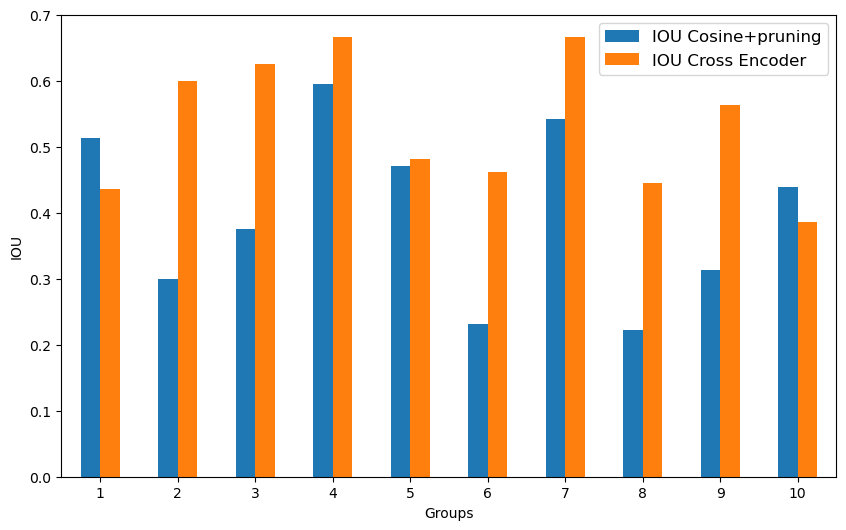

In [30]:
df[['Group', 'IOU Cosine+pruning', 'IOU Cross Encoder']].groupby("Group").mean().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Groups')
plt.ylabel('IOU')
plt.legend(title='hi')
plt.legend(fontsize='large')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

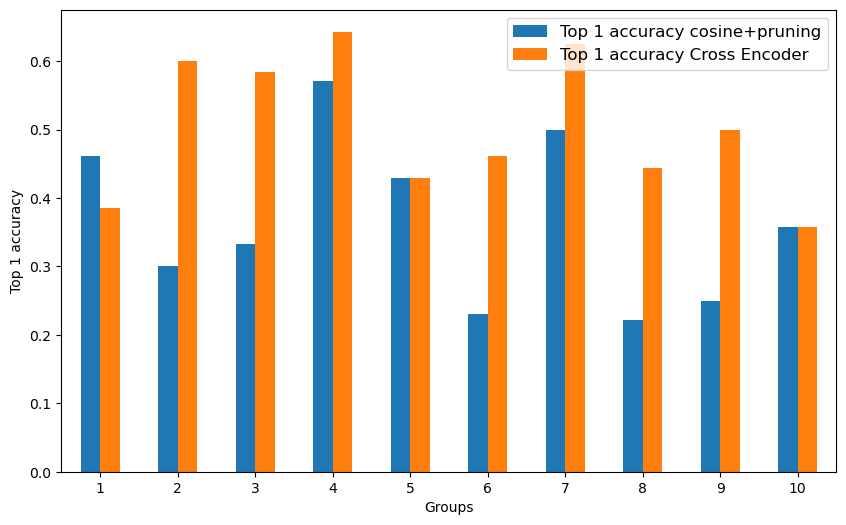

In [31]:
df[['Group', 'Top 1 accuracy cosine+pruning', 'Top 1 accuracy Cross Encoder']].groupby("Group").mean().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Groups')
plt.ylabel('Top 1 accuracy')
plt.legend(title='')
plt.legend(fontsize='large')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

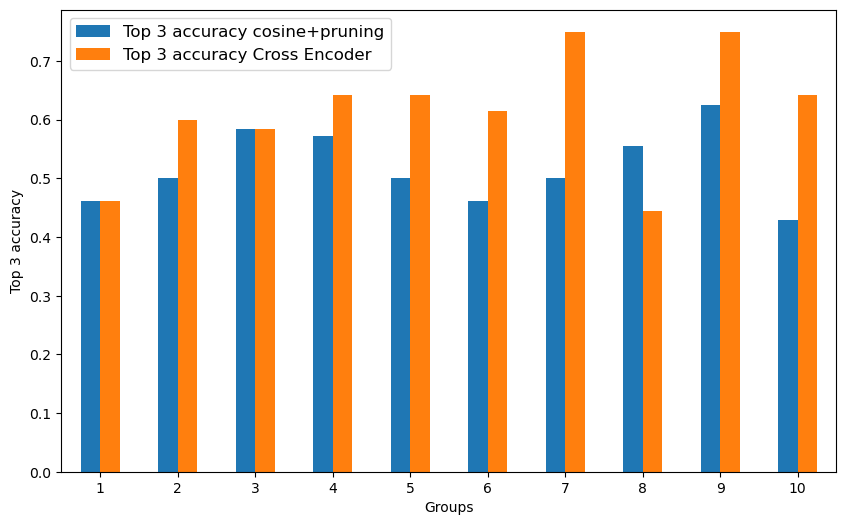

In [32]:
df[['Group', 'Top 3 accuracy cosine+pruning', 'Top 3 accuracy Cross Encoder']].groupby("Group").mean().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Groups')
plt.ylabel('Top 3 accuracy')
plt.legend(title='')
plt.legend(fontsize='large')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

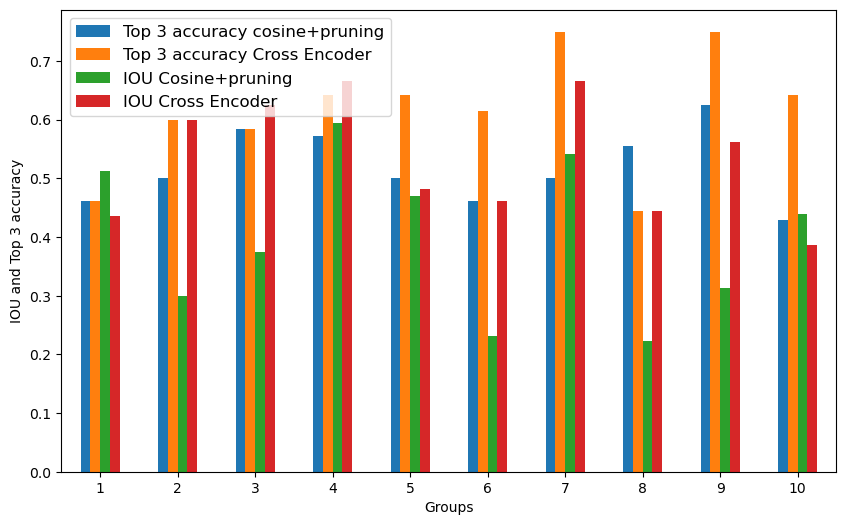

In [33]:
df[['Group', 'Top 3 accuracy cosine+pruning', 'Top 3 accuracy Cross Encoder', 'IOU Cosine+pruning', 'IOU Cross Encoder']].groupby("Group").mean().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Groups')
plt.ylabel('IOU and Top 3 accuracy')
plt.legend(title='hi')
plt.legend(fontsize='large')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

In [45]:
group4 = pd.merge(pd.read_csv("spreadsheets/DP_bert_google_level1_pruned.csv"), pd.read_csv("google_preprocessedlevel1.csv"), on="Transcript", how="outer")
group4 = group4[group4['Group']==4]
group4 = group4.drop_duplicates(subset='Transcript')
group4

,Utt_id,Transcript,Ground truth,Correct,Top 1 prop,Top 1 cosim,Top 1 IOU,Top 2 prop,Top 2 cosim,Top 2 IOU,...,Top 4 prop,Top 4 cosim,Top 4 IOU,Top 5 prop,Top 5 cosim,Top 5 IOU,Unnamed: 0,Common Ground,Label,Group
220,38,tell got red cube 10 grams,red = 10,2,red = 20,0.796155,0.0,red = 10,0.793647,1.0,...,red < 50,0.776903,0.0,red = 30,0.776765,0.0,41,red = 10,1,4
225,39,blue block 's obviously time,blue = 10,0,blue > 40,0.770373,0.0,blue < 40,0.768358,0.0,...,blue < 50,0.765335,0.0,blue = 40,0.764804,0.0,42,blue = 10,1,4
230,40,okay e green block red block 10 long 's dropping,green = 20,0,green = red,0.808078,0.0,green > red,0.797047,0.0,...,"green = 50, red = 10",0.791738,0.0,red > green,0.791317,0.0,43,green = 20,1,4
235,41,n't drop completely consider purple block 30 g...,purple = 30,0,purple = 10,0.756791,0.0,purple = 20,0.753118,0.0,...,purple < 10,0.743221,0.0,purple = 40,0.738244,0.0,44,purple = 30,1,4
255,43,purple block 's purple block 's 20 purple bloc...,purple != 20,0,purple > 10,0.719014,0.0,purple > 20,0.716047,0.0,...,purple = 10,0.715583,0.0,purple = 20,0.712349,0.0,46,purple != 20,1,4
275,45,yellow red blue said yellow block 's 's okay 's,yellow = 50,0,blue = red + yellow,0.754818,0.0,blue > red + yellow,0.754487,0.0,...,red > blue + yellow,0.752267,0.0,yellow > blue + red,0.751261,0.0,48,yellow = 50,1,4
280,46,'ve cut 30 would yellow 50,yellow = 50,3,yellow = 20,0.776066,0.0,yellow = 40,0.774553,0.0,...,yellow = 30,0.770233,0.0,yellow = 10,0.752336,0.0,50,yellow = 50,1,4


In [48]:
group4 = pd.merge(pd.read_csv("spreadsheets/DP_bert_oracle_level1_pruned.csv"), pd.read_csv("oraclePreprocessedlevel1.csv"), on="Transcript", how="outer")
group4 = group4[group4['Group']==4]
group4 = group4.drop_duplicates(subset='Transcript')
group4

,Utt_id,Transcript,Ground truth,Correct,Top 1 prop,Top 1 cosim,Top 1 IOU,Top 2 prop,Top 2 cosim,Top 2 IOU,...,Top 4 prop,Top 4 cosim,Top 4 IOU,Top 5 prop,Top 5 cosim,Top 5 IOU,Unnamed: 0,Common Ground,Label,Group
195,35,I tell red cube ten grams,red = 10,1,red = 10,0.781985,1.000000,red > 10,0.780317,0.0,...,red != 10,0.649074,0.000000,NaN,NaN,NaN,41,red = 10,1,4
320,36,Well top ten,blue = 10,0,blue > 10,0.659159,0.000000,green > 10,0.657503,0.0,...,purple = 10,0.657223,0.000000,green = 10,0.656669,0.0,42,blue = 10,1,4
325,37,easy green block twenty cause red block ten lo...,green = 20,0,"blue = 10, green = 20, red = 20",0.791524,0.333333,"blue = 20, green = 10, red = 20",0.790129,0.0,...,"blue = 10, green = 20, red = 10",0.788113,0.333333,"blue = 10, green = 10, red = 20",0.786427,0.0,43,green = 20,1,4
330,38,n't drop completely consider purple block thir...,purple = 30,1,purple = 30,0.805946,1.000000,purple < 30,0.760957,0.0,...,purple > 30,0.730088,0.000000,NaN,NaN,NaN,44,purple = 30,1,4
350,40,purple block 's purple block 's twenty purple ...,purple != 20,0,"green = 40, purple = 20, red = 20",0.776773,0.000000,"green = 20, purple = 40, red = 40",0.775829,0.0,...,"green = 40, purple = 40, red = 20",0.773687,0.000000,"green = 40, purple = 20, red = 50",0.773565,0.0,46,purple != 20,1,4
370,42,yellow red blue 's 's,yellow = 50,0,red > blue + yellow,0.751342,0.000000,blue > red + yellow,0.750678,0.0,...,red < blue + yellow,0.745137,0.000000,blue < red + yellow,0.743958,0.0,48,yellow = 50,1,4
375,43,blue ten,blue = 10,1,blue = 10,0.805257,1.000000,blue < 10,0.705245,0.0,...,blue != 10,0.685951,0.000000,NaN,NaN,NaN,49,blue = 10,1,4
380,44,would yellow fifty,yellow = 50,1,yellow = 50,0.815154,1.000000,yellow < 50,0.719393,0.0,...,yellow != 50,0.665588,0.000000,NaN,NaN,NaN,50,yellow = 50,1,4


In [49]:
import os

In [54]:
for file in os.listdir():
    if "preprocessed" in file.lower():
        f = pd.read_csv(file)
        f = f[f["Label"]==1]
        utts = f["Transcript"]
        l = [len(utt) for utt in utts]
        print(file)
        print("average utterance length", sum(l)/len(l))
        variance = sum([((x - (sum(l)/len(l))) ** 2) for x in l]) / len(l)
        print("std on utterance length", variance**0.5)
        # print(l)
        print()

oraclePreprocessedlevel1.csv
average utterance length 45.12173913043478
std on utterance length 33.34487714414366

google_preprocessedlevel1.csv
average utterance length 51.14414414414414
std on utterance length 44.402712125357056

google_preprocessedlevel2.csv
average utterance length 39.44736842105263
std on utterance length 22.53207931678632

oraclePreprocessedlevel3.csv
average utterance length 44.2
std on utterance length 28.067062546693407

google_preprocessedlevel3.csv
average utterance length 43.85245901639344
std on utterance length 22.007328187520592

oraclePreprocessedlevel2.csv
average utterance length 39.831460674157306
std on utterance length 27.789431325092803

